## Importing Necessary Libraries

In [29]:
# for dataframe manipulation and analysis
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

# warning filtering library
import warnings
warnings.filterwarnings('ignore')

# for data preprocessing
from sklearn.model_selection import train_test_split

# for model building
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost

# for model evaluation
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

## Loading the dataset

In [30]:
df = pd.read_csv('Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


#### About the dataset-
- The dataset used in this project is Bangalore house dataset, obtained from kaggle.The dataset has various features of a property and its price.

## EDA

In [31]:
# droping duplicates
df.drop_duplicates(inplace = True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12791 entries, 0 to 13318
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     12791 non-null  object 
 1   availability  12791 non-null  object 
 2   location      12790 non-null  object 
 3   size          12775 non-null  object 
 4   society       7463 non-null   object 
 5   total_sqft    12791 non-null  object 
 6   bath          12718 non-null  float64
 7   balcony       12186 non-null  float64
 8   price         12791 non-null  float64
dtypes: float64(3), object(6)
memory usage: 999.3+ KB


## Observation
- There are 12791 records and 9 features.
- There are missing values in the dataset.
- some features are in categorical form so we need encode them.

## Understanding categorical column

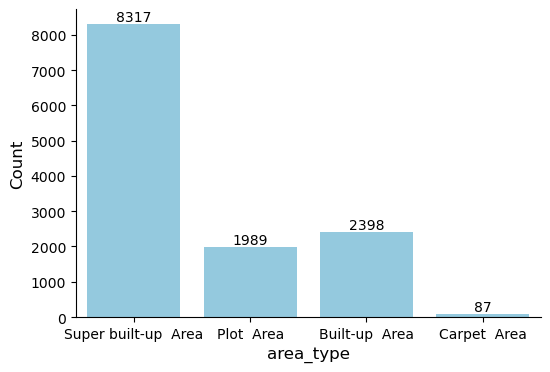

In [33]:
plt.figure(figsize = (6,4))
y = sns.countplot(df['area_type'],color = 'skyblue')
y.bar_label(y.containers[0])
sns.despine()
plt.xlabel('area_type',fontsize = 12)
plt.ylabel('Count',fontsize = 12)
plt.show()

In [34]:
# droping irrelavant features
df = df.drop(['availability','society'],axis = 1)

In [35]:
# treating null values
df.dropna(inplace = True)

## Data cleaning

In [36]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '3 Bedroom', '1 BHK', '1 RK',
       '4 BHK', '1 Bedroom', '2 Bedroom', '6 Bedroom', '8 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '11 Bedroom', '43 Bedroom',
       '14 BHK', '8 BHK', '12 Bedroom', '10 Bedroom', '13 BHK'],
      dtype=object)

In [37]:
df['bhk'] = df['size'].apply(lambda x: int(x.split()[0]))

In [38]:
def convert_sqrt_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [39]:
df['total_sqft'] = df['total_sqft'].apply(convert_sqrt_to_num)

In [40]:
df.dropna(inplace = True)

## Feature Engineering

In [41]:
df['price_per_sqft'] = round(df['price']*100000/df['total_sqft'],2)

In [42]:
location_stats = df['location'].value_counts()
location_less_than_10 = location_stats[location_stats <= 10]

In [43]:
df['location'] =df['location'].apply(lambda x: 'other' if x in location_less_than_10 else x)

## Outlier Detection and Treatment

In [44]:
df = df[~(df['total_sqft']/df['bhk'] < 300)]

<AxesSubplot:>

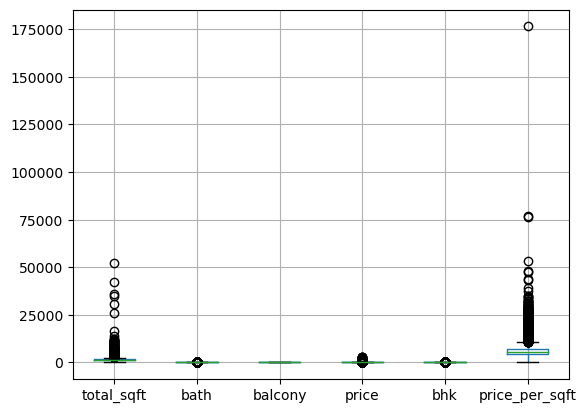

In [45]:
df.boxplot()

In [46]:
def replace_outliers(mydf,col,method = 'quartile',strategy = 'median'):
    if method == 'quartile':
        Q1 = mydf[col].quantile(0.25)
        Q2 = mydf[col].quantile(0.50)        
        Q3 = mydf[col].quantile(0.75)
        IQR = Q3 - Q1
        LW = Q1 - 1.5 * IQR
        UW = Q3 + 1.5 * IQR
    elif method == 'std':
        mean = mydf[col].mean()
        stddev = mydf[col].std()
        LW = mean - (2 * std)
        UW = mean + (2 * std)
    else:
        print('pass a correct method')
    
    # printing the outliers
    outliers = mydf.loc[(mydf[col] < LW) | (mydf[col] > UW),col]
    outliers_density = round(len(outliers)/len(mydf),2)
    if len(outliers) == 0:
        print(f'feature {col} does not have outliers')
    else:
        print(f'feature {col} have outliers')
        print(f'total number of outliers in {col} is {len(outliers)}')
        print(f'outliers density in {col} is {(outliers_density * 100)} %')
        
    if outliers_density * 100 > 2.0:
        if strategy == 'median':
            dropindex1 = mydf.loc[mydf[col] < LW,col].index
            mydf.drop(dropindex1,axis = 0,inplace = True)
            dropindex2 = mydf.loc[mydf[col] > UW,col].index
            mydf.drop(dropindex2,axis = 0,inplace = True)
        elif strategy == 'mean':
            mydf.loc[mydf[col] < LW,col] = mean
            mydf.loc[mydf[col] > UW,col] = mean
    return mydf

In [47]:
for col in df.drop(['area_type','location','size','bath','bhk','price','balcony'],axis = 1).columns:
    replace_outliers(df,col)

feature total_sqft have outliers
total number of outliers in total_sqft is 927
outliers density in total_sqft is 8.0 %
feature price_per_sqft have outliers
total number of outliers in price_per_sqft is 762
outliers density in price_per_sqft is 7.000000000000001 %


## Data preprocessing
- Converting categorical form to numerical form using one hot encoding.

In [48]:
df = pd.get_dummies(df,columns = ['location'])

In [49]:
df = pd.get_dummies(df,columns = ['area_type'])

In [50]:
df = df.drop(['location_other','size'],axis = 1)

## Train Test Split

In [51]:
X = df.drop('price',axis = 1)
y = df['price']

In [52]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 5)

## Model building

In [53]:
def model_builder(estimators):
    for estimator in estimators:
        estimator.fit(X_train,y_train)
        
        # model evaluation
        training_accuracy = estimator.score(X_train,y_train)
        y_pred = estimator.predict(X_test)
        r2score = r2_score(y_test,y_pred)
        rmse = np.sqrt(mean_squared_error(y_test,y_pred))
        
        print('MODEL NAME:',type(estimator).__name__)
        print('\nTraining Accuracy:',round(training_accuracy,4),end = '\t')
        print('Validation Accuracy:',round(r2score,4),end = '\t')
        print('rmse:',round(rmse,4))
        print('\n')

In [54]:
model_builder([LinearRegression(),DecisionTreeRegressor(),KNeighborsRegressor(),
              RandomForestRegressor(),XGBRegressor()])

MODEL NAME: LinearRegression

Training Accuracy: 0.9696	Validation Accuracy: 0.9667	rmse: 6.3583


MODEL NAME: DecisionTreeRegressor

Training Accuracy: 1.0	Validation Accuracy: 0.9982	rmse: 1.4811


MODEL NAME: KNeighborsRegressor

Training Accuracy: 0.9993	Validation Accuracy: 0.9989	rmse: 1.1805


MODEL NAME: RandomForestRegressor

Training Accuracy: 0.9999	Validation Accuracy: 0.9994	rmse: 0.8337


MODEL NAME: XGBRegressor

Training Accuracy: 0.9996	Validation Accuracy: 0.9989	rmse: 1.1447


